# Caso de uso para trabajo fin de grado: Analisis de estrategias clustering en la economía
En este cuaderno se va a realizar un caso de uso vinculado a la segmentación de clientes

# 1. Imports
Se importan las librerias y funciones que se van a utilizar en este caso de uso


In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.stats import mode

# 2. Selección de datos
En este caso, la selección es del computo total de datos que se dispone

In [2]:
datos = pd.read_csv('customer-set.csv', header = 0)
#TODO: quitar la columna de segmentacion.

Echamos un vistazo al dataset cargado:

In [3]:
datos.head(5) 

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6,A


Comprobamos las dimensiones del dataset:

In [4]:
datos.shape 

(8068, 11)

# 3. Analisis exploratorio de los datos y preprocesado de datos 

## 3.1. Valores perdidos

In [6]:
## Genero una mascara booleana con True donde se encuentran los valores perdidos.
is_NaN = datos.isnull()
registro_con_NaN = is_NaN.any(axis=1)

## Filtro los datos para recuperar solamente los registros con valores perdidos.
registro_con_NaN = datos[registro_con_NaN]
registro_con_NaN

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4,A
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6,A
12,461230,Female,No,19,No,Executive,0.0,Low,NaN,Category 3,D
13,459573,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Category 6,A
24,461021,Female,NaN,58,No,Executive,1.0,Average,3.0,Category 3,B
...,...,...,...,...,...,...,...,...,...,...,...
8040,467165,Female,No,25,No,Homemaker,NaN,Low,1.0,Category 6,D
8044,466997,Female,NaN,50,No,Engineer,1.0,Low,2.0,Category 6,D
8047,462396,Male,Yes,50,Yes,Doctor,NaN,Average,2.0,Category 6,C
8049,461292,Female,Yes,81,No,Lawyer,NaN,High,2.0,Category 3,D


Se tienen 1403 registros de cliente con valores perdidos. El siguiente paso es imputar algun valor para reconocerlos y evitar el valor NaN. Los imputaremos con el valor 'Perdido'.

In [7]:
datos = datos.fillna("Perdido") 

Podemos comprobar de nuevo el conjunto de datos para comprobar la sustitucion de valores

In [8]:
datos.head(3) 

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4,D
1,462643,Female,Yes,38,Yes,Engineer,Perdido,Average,3.0,Category 4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6,B


## 3.2. Analisis de datos.
Con el fin de entender mejor nuestros datos y saber situarnos dentro del problema, se generarán graficos para cada variable.

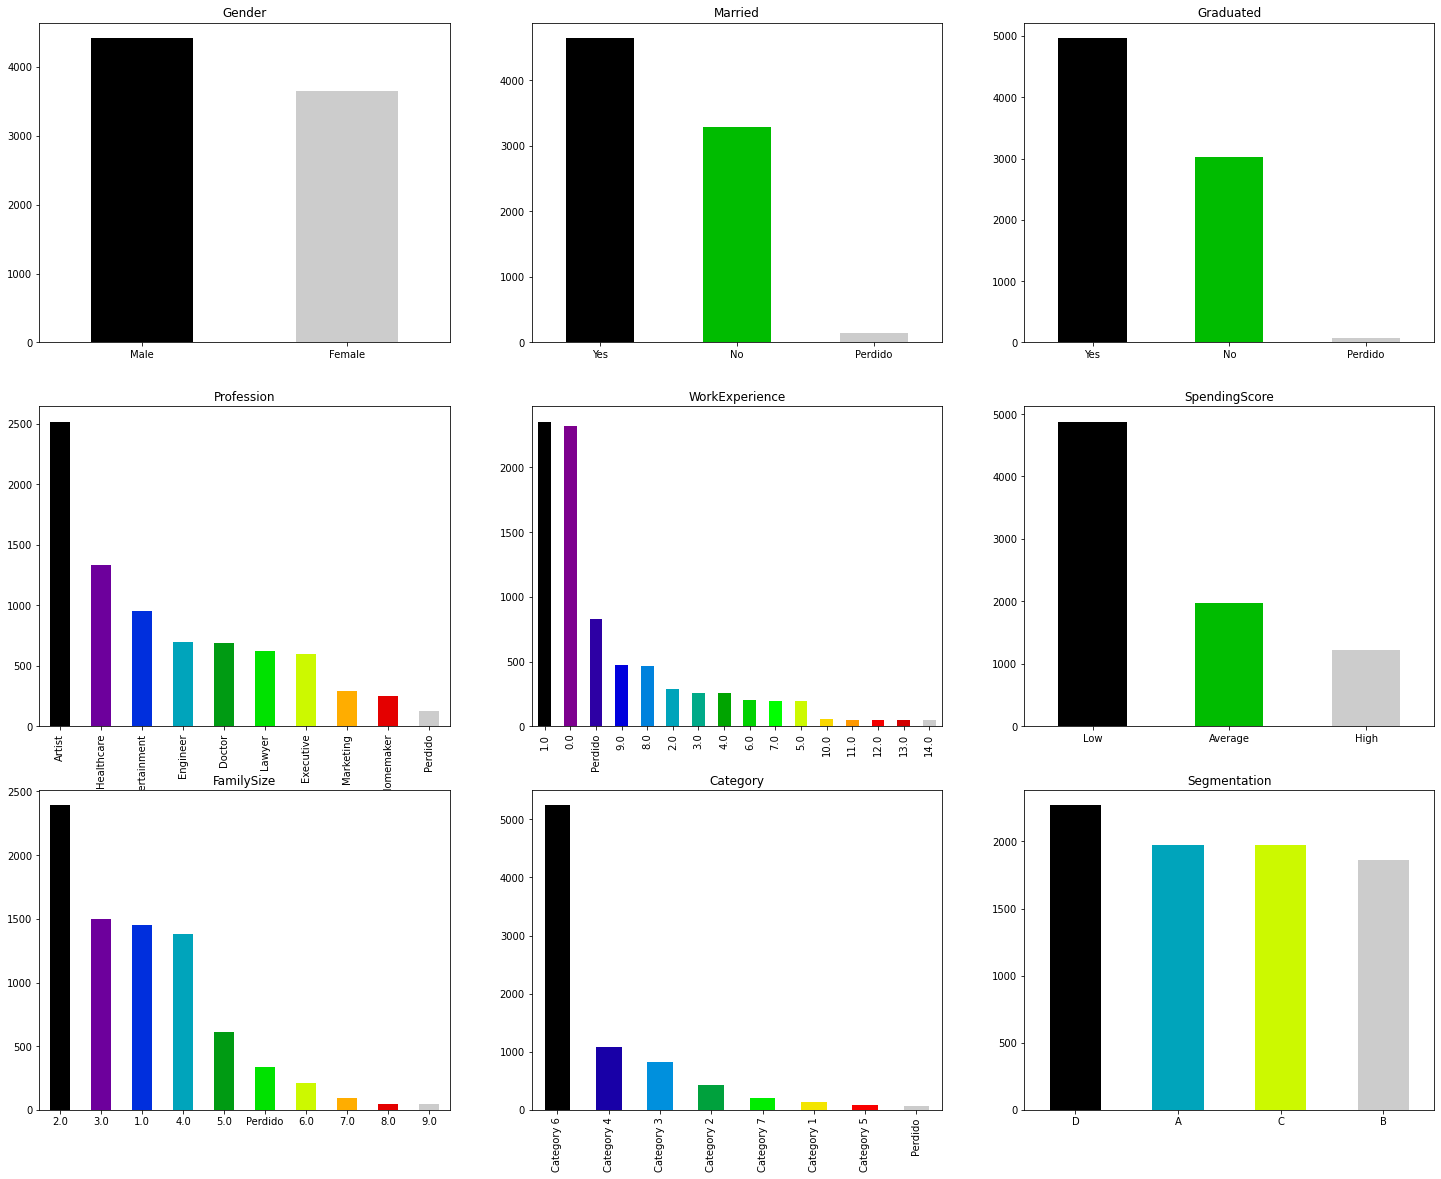

In [9]:
## Definicion de la funcion que ploteará las gráficas.
def grafica(fig, subplot_id, columna, mapa_color, rotacion_etiquetas):
    fig.add_subplot(subplot_id)
    long_color = len(datos[columna].unique())
    color = mapa_color(np.linspace(0, 1, long_color))
    count = datos[columna].value_counts()
    plt.title(columna)
    count.plot(kind='bar', color=color)
    plt.xticks(rotation=rotacion_etiquetas)
    # plt.ylabel("Count")
    
fig = plt.figure(figsize=(25, 20))
grafica(fig, 331, "Gender", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 332, "Married", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 333, "Graduated", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 334, "Profession", plt.cm.nipy_spectral, "vertical")
grafica(fig, 335, "WorkExperience", plt.cm.nipy_spectral, "vertical")
grafica(fig, 336, "SpendingScore", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 337, "FamilySize", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 338, "Category", plt.cm.nipy_spectral, "vertical")
grafica(fig, 339, "Segmentation", plt.cm.nipy_spectral, "horizontal")
plt.show()

Para visualizar la edad, como puede tener muchos valores diferentes, se definen intervalos. En concreto se han establecido 9 intervalos

In [17]:
## Número de intervalos
i = 9
intervalos = [0, 
        int(max(datos['Age'])/i), 
        int(2*max(datos['Age'])/i), 
        int(3*max(datos['Age'])/i), 
        int(4*max(datos['Age'])/i), 
        int(5*max(datos['Age'])/i), 
        int(6*max(datos['Age'])/i), 
        int(7*max(datos['Age'])/i),
       int(8*max(datos['Age'])/i),
        max(datos['Age'])]

intervalos_edad = pd.cut(datos['Age'], bins=intervalos)

In [18]:

## Agrupamos los datos segun el genero e intervalo de edad.
groupby_df = datos.groupby(['Gender', intervalos_edad]).size().reset_index(name='Count')

## Creamos mascaras booleanas para la selección
mascara_mujeres = groupby_df['Gender']=="Female"
mascara_hombres = groupby_df['Gender']=="Male"

## Seleccionamos aplicando las mascaras definidas anteriormente
mujeres_df = groupby_df.loc[mascara_mujeres]
hombres_df = groupby_df.loc[mascara_hombres]

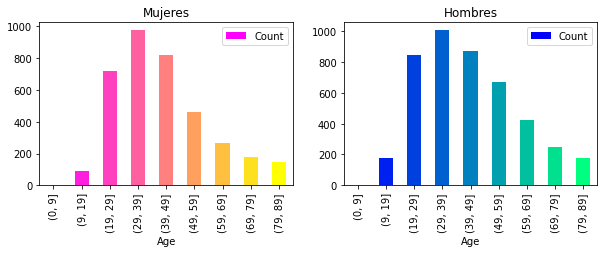

In [19]:
## Configuramos la figura que se va a mostrar. Concretamente dos subfiguras.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

## Elegimos la paleta de color para la visualización
color_mujeres = plt.cm.spring(np.linspace(0, 1, len(mujeres_df['Age'].unique())))
color_hombres = plt.cm.winter(np.linspace(0, 1, len(hombres_df['Age'].unique())))

## Generamos las subfiguras
mujeres_df.plot(x='Age', y='Count', kind = 'bar', color=color_mujeres, title='Mujeres', ax=axes[0])
hombres_df.plot(x='Age', y='Count', kind = 'bar', color=color_hombres, title='Hombres', ax=axes[1])

## Por ultimo mostramos la figura completa
plt.show()

## 3.3 Preprocesado de datos

### 3.3.1 Transformación de los datos

Para emplear las variables categoricas no numericas en las técnicas de clustering, es necesario realizar la transformacion a variables categoricas numéricas. Esto se consigue con la funcion factorize de la libreria Pandas.

In [22]:
datos["Gender"] = pd.factorize(datos["Gender"])[0]
datos["Married"] = pd.factorize(datos["Married"])[0]
datos["Graduated"] = pd.factorize(datos["Graduated"])[0]
datos["Profession"] = pd.factorize(datos["Profession"])[0]
datos["SpendingScore"] = pd.factorize(datos["SpendingScore"])[0]
datos["Category"] = pd.factorize(datos["Category"])[0]

### 3.3.2 Imputacion de valores perdidos

Para evitar los valores perdidos en la ejecucion de las tecnicas de clustering, se procede a imputar los valores 'Perdidos' por la moda en columnas numericas.

In [23]:
datos["WorkExperience"] = datos["WorkExperience"].replace("Perdido",datos["WorkExperience"].mode()[0])
datos["FamilySize"] = datos["FamilySize"].replace("Perdido",datos["FamilySize"].mode()[0])

Podemos comprobar la sustitucion de los valores

In [24]:
datos.head(5) 

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category,Segmentation
0,462809,0,0,22,0,0,1.0,0,4.0,0,D
1,462643,1,1,38,1,1,1.0,1,3.0,0,A
2,466315,1,1,67,1,1,1.0,0,1.0,1,B
3,461735,0,1,67,1,2,0.0,2,2.0,1,B
4,462669,1,1,40,1,3,1.0,2,6.0,1,A


### 3.3.3 Normalización de los datos
La normalización nos permite corregir el posible sesgo de los algoritmos hacia ciertas variables debido a sus escalas, ya que los algoritmos trabajan con calculo de distancias.

In [25]:
## Normalizaremos los datos al intervalo [0,1]
scaler = MinMaxScaler(feature_range=(0, 1)) 

#Normalizaremos todas la variables menos la identificativa de cada cliente
datos_normalizados = scaler.fit_transform(datos.copy().drop(columns=["CustomerID", "Segmentation"]))

## Construyo un nuevo datframe con los datos normalizados
df_normalizado = pd.DataFrame(data=datos_normalizados, columns=datos.columns[1:-1])
df_normalizado.head() # check the result

,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,0.0,0.0,0.056338,0.0,0.000000,0.071429,0.0,0.375,0.000000
1,1.0,0.5,0.281690,0.5,0.111111,0.071429,0.5,0.250,0.000000
2,1.0,0.5,0.690141,0.5,0.111111,0.071429,0.0,0.000,0.142857
3,0.0,0.5,0.690141,0.5,0.222222,0.000000,1.0,0.125,0.142857
4,1.0,0.5,0.309859,0.5,0.333333,0.071429,1.0,0.625,0.142857


# 4. Minería de datos. Clustering

Se van a aplicar las siguientes tecnicas de clustering sobre los datos:
- Clustering particional: K-means, Meanshift
- Clustering jerarquico: Clustering agglomerativo
- Clustering basado en densidad: DBSCAN, OPTICS
- Clustering probabilistico: 

## 4.1 Estudio del numero de clúster optimo para técnicas particionales (K-means)

## 4.2 Clustering

### 4.2.1. Instanciacion de los objetos para realizar el clustering

In [16]:
## KMEANS
kmeans = KMeans(n_clusters=K, random_state=0, max_iter=300, n_init=10, verbose=False)

## MEANSHIFT
bw = estimate_bandwidth(df_normalizado, quantile=0.25, n_samples = 500, random_state = 123456)
meanshift = MeanShift(bandwidth=bw, bin_seeding=True)

## CLUSTERING AGLOMERATIVO
clustering_aglomerativo = AgglomerativeClustering(n_clusters=5, affinity = 'euclidean', linkage='ward')
 
## DBSCAN
dbscan = DBSCAN(eps=0.14)

## OPTICS
optics = OPTICS(min_samples=2, cluster_method='dbscan', max_eps=10)

# TODO
#CLUSTERING PROBABILISTICO

- labels =  [2 1 3 ... 3 3 0]
- count_labels =  [1872 1340 2545 2311]
- centroids.shape =  (4, 9)


In [ ]:

# LLAMADA AL METODO FIT.
## KMEANS
X_train1 = X_train.copy()
labels = kmeans.fit_predict(X_train1)
print("- labels = ", labels)

    # count labels
count_labels = np.bincount(labels)
print("- count_labels = ", count_labels)

    # find centroids
centroids = kmeans.cluster_centers_
print("- centroids.shape = ", centroids.shape)
## MEANSHIFT
## CLUSTERING AGLOMERATIVO
## DBSCAN
## OPTICS
# TODO
#CLUSTERING PROBABILISTICO



## 4.3 Resultados

In [17]:
# name cols as in initial dataset (without last "Segmentation")
cols = df_normalizado.columns[:-1]
df_res = df_normalizado[cols]
# add result labels
df_res["Cluster"] = labels
# insert "CustomerID" for easier understanding
df_res.insert(0, "CustomerID", datos["CustomerID"])
# check the results
df_res.head()

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Cluster
0,462809,0.0,0.0,0.056338,0.0,0.000000,0.071429,0.0,0.375,2
1,462643,1.0,0.5,0.281690,0.5,0.111111,0.071429,0.5,0.250,1
2,466315,1.0,0.5,0.690141,0.5,0.111111,0.071429,0.0,0.000,3
3,461735,0.0,0.5,0.690141,0.5,0.222222,0.000000,1.0,0.125,0
4,462669,1.0,0.5,0.309859,0.5,0.333333,0.071429,1.0,0.625,1


# 5. Evaluación e interpretación de los resultados


## 5.1 Visualización de resultados

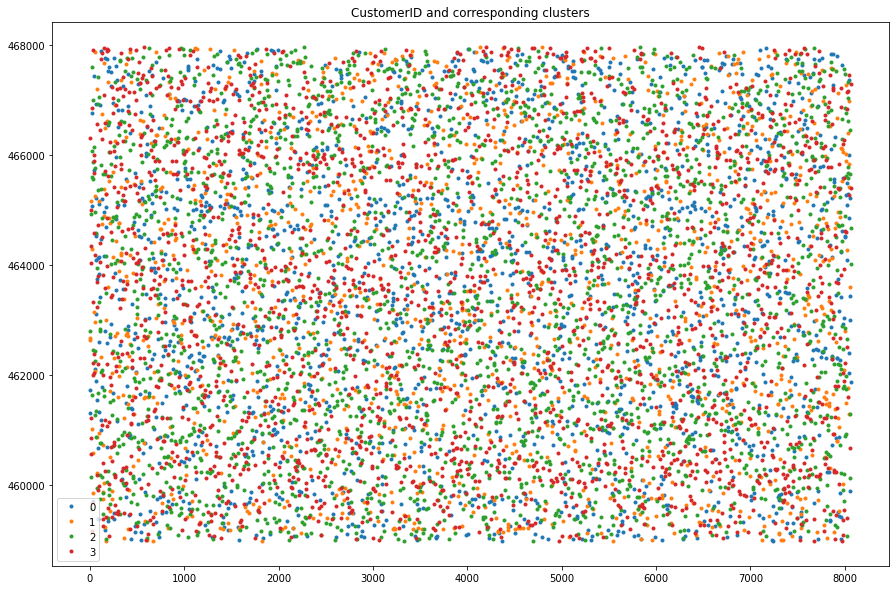

In [18]:
# get unique labels (found clusters id's)
u_labels = np.unique(labels)
plt.figure(figsize=(15,10))
for i in u_labels:
    mask = (df_res["Cluster"] == i)
    plt.plot(df_res[mask]["CustomerID"], ".", label = i)
plt.title('CustomerID and corresponding clusters')
plt.legend()
plt.show()


# 6. Reduccion de la dimensionalidad 
As we can see, we have 9 features in our dataset. Sometimes it is difficult both to solve the clustering problem and to visualize the data with a lot of features in it. That's why I decided to try **reduce data dimension** and check what will happen in this case.

This operation will be made with the help of **(Principal Component Analysis) PCA** method. 



In [19]:
# reduce data only to 2 features
pca = PCA(n_components=2).fit_transform(X_train.copy())
# chech result shape
pca.shape

(8068, 2)

In [20]:
# check the results
print(pca[:3])

[[ 0.30755308 -0.65330463]
 [-0.45827018  0.38141596]
 [-0.53517677  0.14336351]]


## 6.1 Mineria de datos. Clustering.

In [21]:
# initialize k-means
kmeans = KMeans(n_clusters=K, random_state=0, max_iter=ITERS, n_init=RUNS, verbose=False)

# predict the labels of clusters
labels = kmeans.fit_predict(pca)
print("- labels = ", labels)

- labels =  [0 3 1 ... 1 1 2]


In [22]:
pca_res = pd.DataFrame(pca.copy())
pca_res["Cluster"] = labels
pca_res.insert(0, "CustomerID", df["CustomerID"])
pca_res.head()

,CustomerID,0,1,Cluster
0,462809,0.307553,-0.653305,0
1,462643,-0.458270,0.381416,3
2,466315,-0.535177,0.143364,1
3,461735,0.639494,0.649138,2
4,462669,-0.340849,0.784494,3


## 6.2 Visualizacion de resultados con reduccion de dimensionalidad.
As we can see, it is easier to visualize data, when we have 2 dimensions. And the results much prettier.

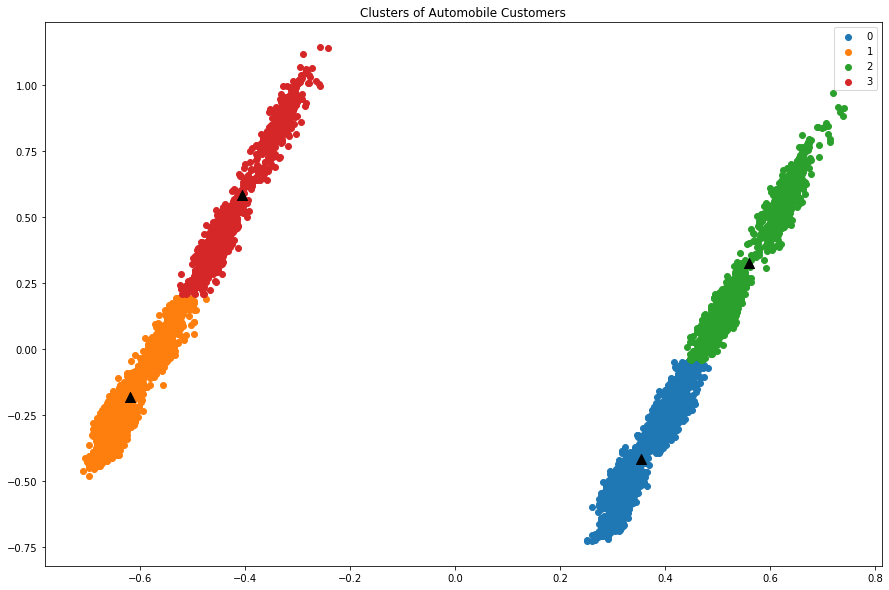

In [23]:
# get the centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(labels)

# plot the results:
plt.figure(figsize=(15,10))
for i in u_labels:
    mask = (pca_res["Cluster"] == i)
    plt.scatter(pca_res.loc[mask][0], pca_res.loc[mask][1], label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k', marker="^")
plt.title('Clusters of Automobile Customers')
plt.legend()
plt.show()